In [2]:
import bz2
import numpy as np
import awkward
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
plt.rcParams.update({"font.size": 20})

import uproot
import vector
import glob
# import networkx as nx
import tqdm
# import numba
import os
import sys
import multiprocessing
from scipy.sparse import coo_matrix

In [3]:
track_coll = "SiTracks_Refitted"
mc_coll = "MCParticles"

In [4]:
#the feature matrices will be saved in this order
particle_feature_order = ["PDG", "charge", "pt", "eta", "sin_phi", "cos_phi", "energy"]

#arrange track and cluster features such that pt (et), eta, phi, p (energy) are in the same spot
#so we can easily use them in skip connections
track_feature_order = [
    "type", "pt", "eta", "sin_phi", "cos_phi", "p",
    "chi2", "ndf", "dEdx", "dEdxError",
    "radiusOfInnermostHit", "tanLambda", "D0", "omega",
    "Z0", "time"
]
cluster_feature_order = [
    "type", "et", "eta", "sin_phi", "cos_phi", "energy",
    "position.x", "position.y", "position.z", "iTheta",
    "energy_ecal", "energy_hcal", "energy_other", "num_hits",
    "sigma_x", "sigma_y", "sigma_z"
]

# Explore a CLIC root file
- adapted from: https://github.com/jpata/particleflow/blob/main/fcc/postprocessing.py

In [5]:
fn = "./reco_p8_ee_qq_ecm380_100001.root"
fi = uproot.open(fn)
arrs = fi["events"]

In [6]:
nevents = len(arrs)
nevents

86

In [7]:
arrs.keys()

['MCParticles',
 'MCParticles/MCParticles.PDG',
 'MCParticles/MCParticles.generatorStatus',
 'MCParticles/MCParticles.simulatorStatus',
 'MCParticles/MCParticles.charge',
 'MCParticles/MCParticles.time',
 'MCParticles/MCParticles.mass',
 'MCParticles/MCParticles.vertex.x',
 'MCParticles/MCParticles.vertex.y',
 'MCParticles/MCParticles.vertex.z',
 'MCParticles/MCParticles.endpoint.x',
 'MCParticles/MCParticles.endpoint.y',
 'MCParticles/MCParticles.endpoint.z',
 'MCParticles/MCParticles.momentum.x',
 'MCParticles/MCParticles.momentum.y',
 'MCParticles/MCParticles.momentum.z',
 'MCParticles/MCParticles.momentumAtEndpoint.x',
 'MCParticles/MCParticles.momentumAtEndpoint.y',
 'MCParticles/MCParticles.momentumAtEndpoint.z',
 'MCParticles/MCParticles.spin.x',
 'MCParticles/MCParticles.spin.y',
 'MCParticles/MCParticles.spin.z',
 'MCParticles/MCParticles.colorFlow.a',
 'MCParticles/MCParticles.colorFlow.b',
 'MCParticles/MCParticles.parents_begin',
 'MCParticles/MCParticles.parents_end',
 'MC

In [7]:
collectionIDs = {k: v for k, v in
    zip(fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_names"][0],
    fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_collectionIDs"][0])}
collectionIDs_reverse = {v: k for k, v in collectionIDs.items()}

In [9]:
prop_data = arrs.arrays([mc_coll, track_coll, "SiTracks_1", "PandoraClusters", "PandoraClusters#1", "PandoraClusters#0", "MergedRecoParticles"])

ModuleNotFoundError: Uproot 4.x can only be used with Awkward 1.x; you have Awkward 2.0.8

In [ ]:
# pip install uproot
# pip install akwward

iev = 0

reco_arr = prop_data["MergedRecoParticles"][iev]
reco_arr = {k.replace("MergedRecoParticles.", ""): reco_arr[k] for k in reco_arr.fields}

reco_p4 = vector.awk(awkward.zip({
    "mass": reco_arr["mass"],
    "x": reco_arr["momentum.x"],
    "y": reco_arr["momentum.y"],
    "z": reco_arr["momentum.z"]}))
reco_arr["pt"] = reco_p4.pt
reco_arr["eta"] = reco_p4.eta
reco_arr["phi"] = reco_p4.phi
reco_arr["energy"] = reco_p4.energy

In [10]:
prop_data.fields

['MCParticles',
 'SiTracks_Refitted',
 'SiTracks_1',
 'PandoraClusters',
 'PandoraClusters#1',
 'PandoraClusters#0',
 'MergedRecoParticles']

# Track features

In [11]:
track_arr = prop_data[track_coll][iev]
feats_from_track = ["type", "chi2", "ndf", "dEdx", "dEdxError", "radiusOfInnermostHit"]
ret = {feat: track_arr[track_coll + "." + feat] for feat in feats_from_track}
n_tr = len(ret["type"])

#FIXME: add additional track features from track state

#get the index of the first track state
trackstate_idx = prop_data[track_coll][track_coll + ".trackStates_begin"][iev]
#get the properties of the track at the first track state (at the origin)
for k in ["tanLambda", "D0", "phi", "omega", "Z0", "time"]:
    ret[k] = prop_data["SiTracks_1"]["SiTracks_1." + k][iev][trackstate_idx]

def track_pt(omega):
    a = 3 * 10**-4
    b = 4  # B-field in tesla, from clicRec_e4h_input

    return a * np.abs(b / omega)

ret["pt"] = track_pt(ret["omega"])
ret["px"] = np.cos(ret["phi"]) * ret["pt"]
ret["py"] = np.sin(ret["phi"]) * ret["pt"]
ret["pz"] = ret["tanLambda"] * ret["pt"]
ret["p"] = np.sqrt(ret["px"]**2 + ret["py"]**2 + ret["pz"]**2)
cos_theta = np.divide(ret["pz"], ret["p"], where=ret["p"]>0)
theta = np.arccos(cos_theta)
tt = np.tan(theta / 2.0)
eta = awkward.to_numpy(-np.log(tt, where=tt>0))
eta[tt<=0] = 0.0
ret["eta"] = eta
ret["sin_phi"] = np.sin(ret["phi"])
ret["cos_phi"] = np.cos(ret["phi"])

#override track type with 1
ret["type"] = 1*np.ones(n_tr, dtype=np.float32)

awkward.Record(ret)

<Record ... 0.795, -0.711, -0.409, -0.231]} type='{"type": var * float64, "chi2"...'>

In [20]:
trk_to_gen_trkidx = sitrack_links["SiTracksMCTruthLink#0"]["SiTracksMCTruthLink#0.index"][iev]
trk_to_gen_genidx = sitrack_links["SiTracksMCTruthLink#1"]["SiTracksMCTruthLink#1.index"][iev]
trk_to_gen_w = sitrack_links["SiTracksMCTruthLink"]["SiTracksMCTruthLink.weight"][iev]

In [36]:
def gen_to_features(prop_data, iev):
    gen_arr = prop_data[mc_coll][iev]
    gen_arr = {k.replace(mc_coll+".", ""): gen_arr[k] for k in gen_arr.fields}

    MCParticles_p4 = vector.awk(awkward.zip({
        "mass": gen_arr["mass"],
        "x": gen_arr["momentum.x"],
        "y": gen_arr["momentum.y"],
        "z": gen_arr["momentum.z"]}))
    gen_arr["pt"] = MCParticles_p4.pt
    gen_arr["eta"] = MCParticles_p4.eta
    gen_arr["phi"] = MCParticles_p4.phi
    gen_arr["energy"] = MCParticles_p4.energy

    return awkward.Record({
        "PDG": gen_arr["PDG"],
        "generatorStatus": gen_arr["generatorStatus"],
        "charge": gen_arr["charge"],
        "pt": gen_arr["pt"],
        "eta": gen_arr["eta"],
        "phi": gen_arr["phi"],
        "energy": gen_arr["energy"],
        })

In [37]:
gen_features = gen_to_features(prop_data, iev)

In [40]:
gen_features["PDG"][gen_features["generatorStatus"]==1]

<Array [22, 22, 22, 22, ... 22, 22, 22, 22] type='55 * int64'>

In [25]:
trk_to_gen_genidx

<Array [107, 89, 92, 79, ... 123, 130, 75, 129] type='25 * int32'>

In [24]:
trk_to_gen_trkidx

<Array [12, 9, 16, 15, 10, ... 6, 4, 3, 0, 2] type='25 * int32'>

In [30]:
trk_to_gen_genidx.to_numpy()

array([107,  89,  92,  79,  91,  78, 131,  81, 121, 116, 124, 126, 111,
       206,  84,  83, 113, 115, 128, 109, 125, 123, 130,  75, 129],
      dtype=int32)

In [151]:
trk_to_gen_trkidx.to_numpy()

array([12,  9, 16, 15, 10,  5,  1,  8, 23, 20,  7, 17, 11, 11, 22, 21, 19,
       18, 14, 13,  6,  4,  3,  0,  2], dtype=int32)

In [152]:
trk_to_gen_genidx[trk_to_gen_trkidx.to_numpy()==11]

<Array [111, 206] type='2 * int32'>

In [155]:
len(trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==11])

2

In [159]:
len(trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==11])==2

False

In [162]:
trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==11]

<Array [] type='0 * float32'>

In [258]:
num = 0
den = 0
for ev in range(nevents):
    
    trk_to_gen_trkidx = sitrack_links["SiTracksMCTruthLink#0"]["SiTracksMCTruthLink#0.index"][ev]
    trk_to_gen_genidx = sitrack_links["SiTracksMCTruthLink#1"]["SiTracksMCTruthLink#1.index"][ev]
    
    for trk_ind in np.unique(trk_to_gen_trkidx.to_numpy()):
        if len(trk_to_gen_genidx[trk_to_gen_trkidx.to_numpy()==trk_ind])>1:
            num += 1
        den +=1

num/den        

0.05863039399624766

In [238]:
sorted_arr = np.sort(w)[::-1]

print(sorted_arr)

[0.8 0.2]


In [250]:
w

array([0.2, 0.8], dtype=float32)

In [251]:
max_idx = np.argmax(w)
indices = np.where(w != w[max_idx])[0]

In [253]:
indices.tolist()

[0]

In [278]:
gen_with_min_w[3]

[[221], [248], [221], [248]]

In [224]:
trk_to_gen_trkidx

<Array [1, 42, 42, 30, 44, ... 19, 24, 16, 2] type='47 * int32'>

In [328]:
    trk_to_gen_trkidx = sitrack_links["SiTracksMCTruthLink#0"]["SiTracksMCTruthLink#0.index"][0]
    trk_to_gen_genidx = sitrack_links["SiTracksMCTruthLink#1"]["SiTracksMCTruthLink#1.index"][0]
    trk_to_gen_w = sitrack_links["SiTracksMCTruthLink"]["SiTracksMCTruthLink.weight"][0]
    

In [337]:
trk_to_gen_trkidx

<Array [12, 9, 16, 15, 10, ... 6, 4, 3, 0, 2] type='25 * int32'>

In [338]:
for trk_ind in np.unique(trk_to_gen_trkidx.to_numpy()):
    w = trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==trk_ind].to_numpy()   
    max_idx = np.argmax(w)    
    print(w, max_idx, trk_to_gen_genidx[trk_ind])

[1.] 0 107
[1.] 0 89
[1.] 0 92
[1.] 0 79
[1.] 0 91
[1.] 0 78
[1.] 0 131
[1.] 0 81
[1.] 0 121
[1.] 0 116
[1.] 0 124
[0.9 0.1] 0 126
[1.] 0 111
[1.] 0 206
[1.] 0 84
[1.] 0 83
[1.] 0 113
[1.] 0 115
[1.] 0 128
[1.] 0 109
[1.] 0 125
[1.] 0 123
[1.] 0 130
[1.] 0 75


In [416]:
trk_to_gen_trkidx

array([ 1, 42, 42, 30, 44, 44, 10, 18, 14, 13, 11,  8, 32, 25, 36, 23, 41,
       43, 37, 34, 33, 39, 17,  4, 40, 31, 12, 38,  6, 21,  5,  3, 26, 29,
       22, 20, 27, 28,  9,  7,  0, 15, 35, 19, 24, 16,  2], dtype=int32)

In [417]:
trk_to_gen_genidx

array([136, 588, 587, 226, 588, 587, 157, 186, 155, 142, 174, 115, 215,
       163, 126, 143, 168, 593, 107, 121, 146, 158, 216, 153, 165, 108,
       120, 187, 151, 177, 135, 180, 129, 225, 145, 106, 173, 171, 118,
       111, 100, 181, 114, 172, 178, 149, 137], dtype=int32)

In [430]:
trk_to_gen_w

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8999999761581421,
 0.10000000149011612,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [444]:
calohit_to_gen_gen_idx==

array([134, 134, 134, ..., 115,  75,  75], dtype=int32)

In [445]:
trk_to_gen_genidx

array([136, 588, 587, 226, 588, 587, 157, 186, 155, 142, 174, 115, 215,
       163, 126, 143, 168, 593, 107, 121, 146, 158, 216, 153, 165, 108,
       120, 187, 151, 177, 135, 180, 129, 225, 145, 106, 173, 171, 118,
       111, 100, 181, 114, 172, 178, 149, 137], dtype=int32)

In [478]:
energy = {}
energy["gen_max"] = []
energy["gen_min"] = []
energy["calo_max"] = []
energy["calo_min"] = []

for ev in range(nevents):

    # retrieve info from event
    gen_features = gen_to_features(prop_data, ev)
    
    trk_to_gen_trkidx = sitrack_links["SiTracksMCTruthLink#0"]["SiTracksMCTruthLink#0.index"][ev].to_numpy()
    trk_to_gen_genidx = sitrack_links["SiTracksMCTruthLink#1"]["SiTracksMCTruthLink#1.index"][ev].to_numpy()
    trk_to_gen_w = sitrack_links["SiTracksMCTruthLink"]["SiTracksMCTruthLink.weight"][ev].to_numpy()

    calohit_to_gen_gen_idx = calohit_links["CalohitMCTruthLink#1"]["CalohitMCTruthLink#1.index"][ev].to_numpy()
    calohit_to_gen_weight = calohit_links["CalohitMCTruthLink"]["CalohitMCTruthLink.weight"][ev].to_numpy()

    # for any weight that is one
    for gen_ind in trk_to_gen_genidx[trk_to_gen_w==1].tolist():
        energy["gen_max"].append(gen_features["energy"][gen_ind])
        energy["calo_max"].append(calohit_to_gen_weight[calohit_to_gen_gen_idx==gen_ind].sum())

    # for any weight that is not one
    for gen_ind in trk_to_gen_genidx[trk_to_gen_w!=1].tolist():
        energy["gen_min"].append(gen_features["energy"][gen_ind])
        energy["calo_min"].append(calohit_to_gen_weight[calohit_to_gen_gen_idx==gen_ind].sum())

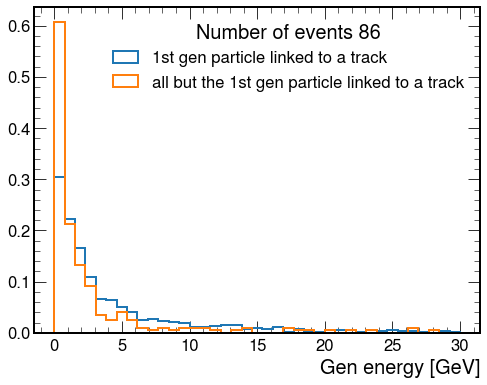

In [479]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 30, 40)

ax.hist(energy["gen_max"], 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
        label="1st gen particle linked to a track"
       )

ax.hist(energy["gen_min"], 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
        label="all but the 1st gen particle linked to a track"
       )
ax.legend(title=f"Number of events {nevents}")
ax.set_xlabel("Gen energy [GeV]");
# ax.set_yscale("log")
# ax.set_ylim(0, 25000)

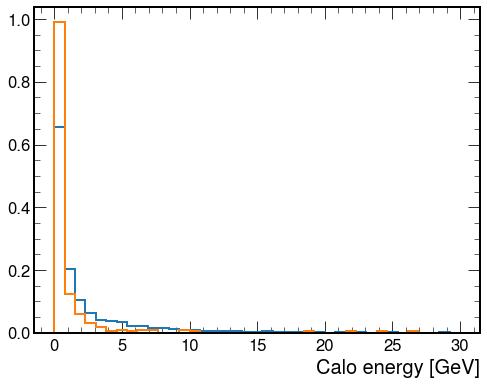

In [482]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 30, 40)

ax.hist(energy["calo_max"], 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
        label="1st gen particle linked to a track"
       )

ax.hist(energy["calo_min"], 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
        label="all but the 1st gen particle linked to a track"
       )
ax.legend(title=f"Number of events {nevents}")
ax.set_xlabel("Calo energy [GeV]");
# ax.set_yscale("log")
# ax.set_ylim(0, 25000)

In [ ]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 30, 40)

ax.hist(energy0_, 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
        label="1st gen particle linked to a track"
       )

ax.hist(energy_, 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
        label="all but the 1st gen particle linked to a track"
       )
ax.legend(title=f"Number of events {nevents}")
ax.set_xlabel("Gen energy [GeV]");
# ax.set_yscale("log")
# ax.set_ylim(0, 25000)

In [175]:
num/den

0.05863039399624766

In [163]:
max_weight = []
for ev in range(nevents):
    
    trk_to_gen_trkidx = sitrack_links["SiTracksMCTruthLink#0"]["SiTracksMCTruthLink#0.index"][ev]
    trk_to_gen_genidx = sitrack_links["SiTracksMCTruthLink#1"]["SiTracksMCTruthLink#1.index"][ev]
    trk_to_gen_w = sitrack_links["SiTracksMCTruthLink"]["SiTracksMCTruthLink.weight"][ev]
    
    for trk_ind in np.unique(trk_to_gen_trkidx.to_numpy()):
        if len(trk_to_gen_genidx[trk_to_gen_trkidx.to_numpy()==trk_ind])==2:
            max_weight.append(trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==trk_ind].to_numpy().max())
            
        elif len(trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==trk_ind])>2:
            print(trk_to_gen_w[trk_to_gen_trkidx.to_numpy()==trk_ind])
        

[0.25, 0.25, 0.5]
[0.333, 0.333, 0.333]
[0.333, 0.333, 0.333]
[0.25, 0.25, 0.25, 0.25]
[0.333, 0.333, 0.333]
[0.333, 0.333, 0.333]
[0.333, 0.333, 0.333]
[0.333, 0.333, 0.333]
[0.333, 0.333, 0.333]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


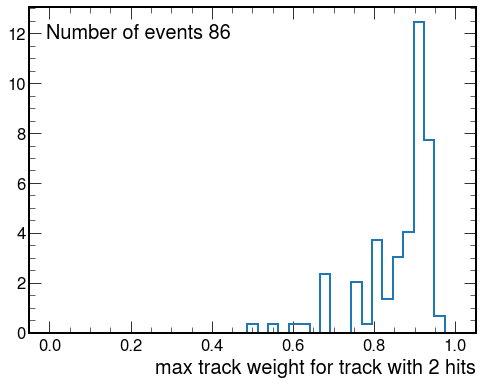

In [166]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 1, 40)

ax.hist(max_weight, 
        bins, 
        histtype="step", 
        linewidth=2, 
        density=True,
#         label="cell_sum_all"
       )
ax.legend(title=f"Number of events {nevents}")
ax.set_xlabel("max track weight for track with 2 hits");
# ax.set_yscale("log")
# ax.set_ylim(0, 25000)

In [41]:
    calohit_to_gen_weight = calohit_links["CalohitMCTruthLink"]["CalohitMCTruthLink.weight"][iev]
    calohit_to_gen_calo_colid = calohit_links["CalohitMCTruthLink#0"]["CalohitMCTruthLink#0.collectionID"][iev]
    calohit_to_gen_gen_colid = calohit_links["CalohitMCTruthLink#1"]["CalohitMCTruthLink#1.collectionID"][iev]
    calohit_to_gen_calo_idx = calohit_links["CalohitMCTruthLink#0"]["CalohitMCTruthLink#0.index"][iev]
    calohit_to_gen_gen_idx = calohit_links["CalohitMCTruthLink#1"]["CalohitMCTruthLink#1.index"][iev]

In [42]:
calohit_to_gen_weight

<Array [0.0162, 0.00309, ... 0.0195, 0.0229] type='6477 * float32'>

In [43]:
calohit_to_gen_calo_colid

<Array [46, 46, 46, 46, 46, ... 50, 50, 51, 51] type='6477 * int32'>

In [44]:
calohit_to_gen_gen_colid

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='6477 * int32'>

In [45]:
# index of cell
calohit_to_gen_calo_idx

<Array [68, 117, 118, 119, ... 586, 587, 0, 1] type='6477 * int32'>

In [46]:
# index of gen particle that hit cell above
calohit_to_gen_gen_idx

<Array [134, 134, 134, 134, ... 115, 75, 75] type='6477 * int32'>

In [64]:
awkward.sum(calohit_to_gen_weight[calohit_to_gen_gen_idx==134])

9.626367

In [67]:
calohit_to_gen_weight[calohit_to_gen_gen_idx==134].to_numpy().sum()

9.626367

In [72]:
gen_features["energy"][134]

17.506936578657633

In [77]:
np.unique(calohit_to_gen_gen_idx.to_numpy())

array([ 13,  75,  76,  77,  78,  79,  81,  83,  84,  89,  91,  92, 103,
       104, 106, 115, 117, 118, 119, 120, 123, 124, 125, 128, 129, 130,
       131, 132, 133, 134, 135, 137, 138, 141, 142, 144, 145, 146, 147,
       148, 149, 184, 223, 224, 235, 238, 241, 248, 249, 257, 259, 266,
       274, 275, 276, 294, 314, 315, 323], dtype=int32)

In [353]:
calohit_to_gen_gen_idx

<Array [180, 120, 120, 223, ... 181, 111, 111] type='5598 * int32'>

In [354]:
calohit_to_gen_weight

<Array [0.148, 0.00399, ... 0.0508, 0.146] type='5598 * float32'>

In [ ]:
calohit_to_gen_weight[calohit_to_gen_gen_idx==gen_idx].sum()

In [352]:
gen_energy_all = []
cell_sum_all = []

for ev in range(nevents):
    gen_features = gen_to_features(prop_data, ev)
    calohit_to_gen_weight = calohit_links["CalohitMCTruthLink"]["CalohitMCTruthLink.weight"][ev]
    calohit_to_gen_gen_idx = calohit_links["CalohitMCTruthLink#1"]["CalohitMCTruthLink#1.index"][ev]

    for gen_idx in np.unique(calohit_to_gen_gen_idx.to_numpy()):
    
        gen_energy_all.append(gen_features["energy"][gen_idx])
        cell_sum_all.append(calohit_to_gen_weight[calohit_to_gen_gen_idx==gen_idx].to_numpy().sum())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


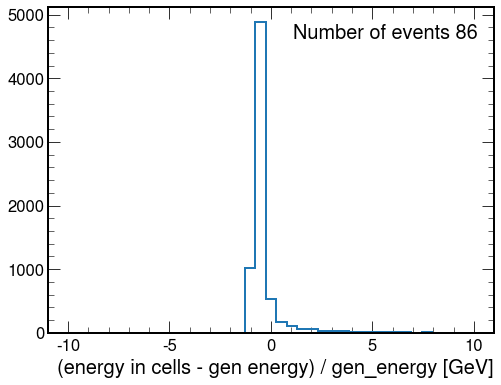

In [140]:
plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(-10, 10, 40)
# ax.hist(gen_energy_all, 
#         bins, 
#         histtype="step", 
#         linewidth=2, 
# #         density=True,
#         label="gen_energy_all"
#        )
num = np.array(cell_sum_all)-np.array(gen_energy_all)
den = np.array(gen_energy_all)

ax.hist(num/den, 
        bins, 
        histtype="step", 
        linewidth=2, 
#         density=True,
#         label="cell_sum_all"
       )
ax.legend(title=f"Number of events {nevents}")
ax.set_xlabel("(energy in cells - gen energy) / gen_energy [GeV]");
# ax.set_yscale("log")
# ax.set_ylim(0, 25000)

Text(0, 1, 'gen energy [GeV]')

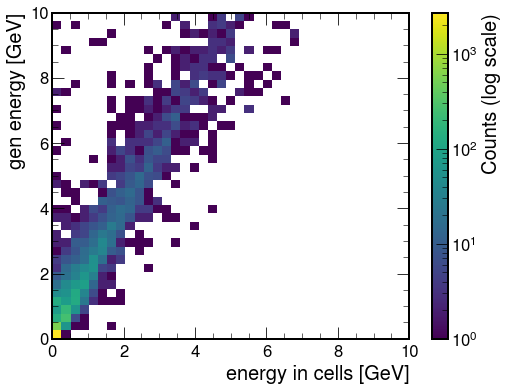

In [135]:
from matplotlib.colors import LogNorm

plt.rcParams.update({"font.size": 20})
fig, ax = plt.subplots(figsize=(8,6))

bins = np.linspace(0, 10, 40)
h = ax.hist2d(np.array(cell_sum_all), np.array(gen_energy_all),
        bins, 
        norm=LogNorm()
         )
# Add a colorbar
cbar = fig.colorbar(h[3], ax=ax)
cbar.ax.set_ylabel('Counts (log scale)')

ax.set_xlabel("energy in cells [GeV]");
ax.set_ylabel("gen energy [GeV]")
# ax.set_yscale("log")
# ax.set_ylim(0, 25000)

In [47]:
hit_features, genparticle_to_hit, hit_idx_local_to_global = get_calohit_matrix_and_genadj(hit_data, calohit_links, iev, collectionIDs)

RuntimeError: Unable to cast Python instance to C++ type (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

In [51]:
    feats = ["type", "cellID", "energy", "energyError", "time", "position.x", "position.y", "position.z"]
    
    hit_idx_global = 0
    hit_idx_global_to_local = {}
    hit_feature_matrix = []


In [ ]:
    for col in sorted(hit_data.keys()):
        icol = collectionIDs[col]
        hit_features = hits_to_features(hit_data[col], iev, col, feats)
        hit_feature_matrix.append(hit_features)
        for ihit in range(len(hit_data[col][col+".energy"][iev])):
            hit_idx_global_to_local[hit_idx_global] = (icol, ihit)
            hit_idx_global += 1
    hit_idx_local_to_global = {v: k for k, v in hit_idx_global_to_local.items()}
    hit_feature_matrix = awkward.Record({
        k: awkward.concatenate([hit_feature_matrix[i][k] for i in range(len(hit_feature_matrix))]) for k in hit_feature_matrix[0].fields})


In [52]:
col

'ECALBarrel'

In [53]:
collectionIDs[col]

46

In [58]:
hit_data

{'ECALBarrel': <Array [{'ECALBarrel.cellID': [, ... ] type='100 * {"ECALBarrel.cellID": var * u...'>,
 'ECALEndcap': <Array [{'ECALEndcap.cellID': [, ... ] type='100 * {"ECALEndcap.cellID": var * u...'>,
 'ECALOther': <Array [{'ECALOther.cellID': [, ... ] type='100 * {"ECALOther.cellID": var * uin...'>,
 'HCALBarrel': <Array [{'HCALBarrel.cellID': [, ... ] type='100 * {"HCALBarrel.cellID": var * u...'>,
 'HCALEndcap': <Array [{'HCALEndcap.cellID': [, ... ] type='100 * {"HCALEndcap.cellID": var * u...'>,
 'HCALOther': <Array [{'HCALOther.cellID': [, ... ] type='100 * {"HCALOther.cellID": var * uin...'>,
 'MUON': <Array [{'MUON.cellID': [], ... ] type='100 * {"MUON.cellID": var * uint64, "MUO...'>}

In [ ]:
def hits_to_features(hit_data, iev, coll, feats):
    feat_arr = {f: hit_data[coll + "." + f][iev] for f in feats}

    sdcoll = "subdetector"
    feat_arr[sdcoll] = np.zeros(len(feat_arr["type"]), dtype=np.int32)
    if coll.startswith("ECAL"):
        feat_arr[sdcoll][:] = 0
    elif coll.startswith("HCAL"):
        feat_arr[sdcoll][:] = 1
    else:
        feat_arr[sdcoll][:] = 2

    pos_mag = np.sqrt(feat_arr["position.x"]**2 + feat_arr["position.y"]**2 + feat_arr["position.z"]**2) 
    px = (feat_arr["position.x"] / pos_mag) * feat_arr["energy"]
    py = (feat_arr["position.y"] / pos_mag) * feat_arr["energy"]
    pz = (feat_arr["position.z"] / pos_mag) * feat_arr["energy"]
    feat_arr["et"] = np.sqrt(px**2+py**2)
    feat_arr["eta"] = 0.5*np.log((feat_arr["energy"] + pz)/(feat_arr["energy"] - pz))
    feat_arr["sin_phi"] = py/feat_arr["energy"]
    feat_arr["cos_phi"] = px/feat_arr["energy"]
    return awkward.Record(feat_arr)

In [23]:
trk_to_gen_w

<Array [1, 1, 1, 1, 1, 1, ... 1, 1, 1, 1, 1, 1] type='25 * float32'>

In [12]:
ret

{'type': array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1.], dtype=float32),
 'chi2': <Array [11.5, 15, 33.1, ... 47.1, 11.9, 38.4] type='24 * float32'>,
 'ndf': <Array [25, 19, 17, 17, 19, ... 9, 29, 25, 7] type='24 * int32'>,
 'dEdx': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='24 * float32'>,
 'dEdxError': <Array [0, 0, 0, 0, 0, 0, ... 0, 0, 0, 0, 0, 0] type='24 * float32'>,
 'radiusOfInnermostHit': <Array [31.7, 31.2, 31.2, ... 31.2, 34.2, 31.4] type='24 * float32'>,
 'tanLambda': <Array [2.84, -0.731, -0.764, ... 4.8, -1.38] type='24 * float32'>,
 'D0': <Array [0.00265, 0.00044, ... 0.145, -0.298] type='24 * float32'>,
 'phi': <Array [2.94, -0.0317, 0.0552, ... -1.99, -1.8] type='24 * float32'>,
 'omega': <Array [3.88e-05, -0.000135, ... -0.00846] type='24 * float32'>,
 'Z0': <Array [-0.00233, -0.0105, ... 0.519, 0.385] type='24 * float32'>,
 'time': <Array [-1, -1, -1, -1, -1, ... -1, -1, -1, -1] type='24 * flo

In [13]:
# number of tracks
len(ret['p'])

24

# Cluster features

In [55]:
def hit_cluster_adj(prop_data, hit_idx_local_to_global, iev):
    coll_arr = prop_data["PandoraClusters#1"]["PandoraClusters#1.collectionID"][iev]
    idx_arr = prop_data["PandoraClusters#1"]["PandoraClusters#1.index"][iev]
    hits_begin = prop_data["PandoraClusters"]["PandoraClusters.hits_begin"][iev]
    hits_end = prop_data["PandoraClusters"]["PandoraClusters.hits_end"][iev]

    #index in the array of all hits
    hit_to_cluster_matrix_coo0 = []
    #index in the cluster array
    hit_to_cluster_matrix_coo1 = []

    #weight
    hit_to_cluster_matrix_w = []

    #loop over all clusters
    for icluster in range(len(hits_begin)):

        #get the slice in the hit array corresponding to this cluster
        hbeg = hits_begin[icluster]
        hend = hits_end[icluster]
        idx_range = idx_arr[hbeg:hend]
        coll_range = coll_arr[hbeg:hend]

        #add edges from hit to cluster
        for icol, idx in zip(coll_range, idx_range):
            hit_to_cluster_matrix_coo0.append(hit_idx_local_to_global[(icol, idx)])
            hit_to_cluster_matrix_coo1.append(icluster)
            hit_to_cluster_matrix_w.append(1.0)
    return np.array(hit_to_cluster_matrix_coo0), np.array(hit_to_cluster_matrix_coo1), np.array(hit_to_cluster_matrix_w)

def get_calohit_matrix_and_genadj(hit_data, calohit_links, iev, collectionIDs):
    feats = ["type", "cellID", "energy", "energyError", "time", "position.x", "position.y", "position.z"]
    
    hit_idx_global = 0
    hit_idx_global_to_local = {}
    hit_feature_matrix = []
    for col in sorted(hit_data.keys()):
        icol = collectionIDs[col]
        hit_features = hits_to_features(hit_data[col], iev, col, feats)
        hit_feature_matrix.append(hit_features)
        for ihit in range(len(hit_data[col][col+".energy"][iev])):
            hit_idx_global_to_local[hit_idx_global] = (icol, ihit)
            hit_idx_global += 1
    hit_idx_local_to_global = {v: k for k, v in hit_idx_global_to_local.items()}
    hit_feature_matrix = awkward.Record({
        k: awkward.concatenate([hit_feature_matrix[i][k] for i in range(len(hit_feature_matrix))]) for k in hit_feature_matrix[0].fields})

    #add all edges from genparticle to calohit
    calohit_to_gen_weight = calohit_links["CalohitMCTruthLink"]["CalohitMCTruthLink.weight"][iev]
    calohit_to_gen_calo_colid = calohit_links["CalohitMCTruthLink#0"]["CalohitMCTruthLink#0.collectionID"][iev]
    calohit_to_gen_gen_colid = calohit_links["CalohitMCTruthLink#1"]["CalohitMCTruthLink#1.collectionID"][iev]
    calohit_to_gen_calo_idx = calohit_links["CalohitMCTruthLink#0"]["CalohitMCTruthLink#0.index"][iev]
    calohit_to_gen_gen_idx = calohit_links["CalohitMCTruthLink#1"]["CalohitMCTruthLink#1.index"][iev]
    genparticle_to_hit_matrix_coo0 = []
    genparticle_to_hit_matrix_coo1 = []
    genparticle_to_hit_matrix_w = []
    for calo_colid, calo_idx, gen_colid, gen_idx, w in zip(calohit_to_gen_calo_colid, calohit_to_gen_calo_idx, calohit_to_gen_gen_colid, calohit_to_gen_gen_idx, calohit_to_gen_weight):
        genparticle_to_hit_matrix_coo0.append(gen_idx)
        genparticle_to_hit_matrix_coo1.append(hit_idx_local_to_global[(calo_colid, calo_idx)])
        genparticle_to_hit_matrix_w.append(w)

    return hit_feature_matrix, (genparticle_to_hit_matrix_coo0, genparticle_to_hit_matrix_coo1, genparticle_to_hit_matrix_w), hit_idx_local_to_global


def hits_to_features(hit_data, iev, coll, feats):
    feat_arr = {f: hit_data[coll + "." + f][iev] for f in feats}

    sdcoll = "subdetector"
    feat_arr[sdcoll] = np.zeros(len(feat_arr["type"]), dtype=np.int32)
    if coll.startswith("ECAL"):
        feat_arr[sdcoll][:] = 0
    elif coll.startswith("HCAL"):
        feat_arr[sdcoll][:] = 1
    else:
        feat_arr[sdcoll][:] = 2

    pos_mag = np.sqrt(feat_arr["position.x"]**2 + feat_arr["position.y"]**2 + feat_arr["position.z"]**2) 
    px = (feat_arr["position.x"] / pos_mag) * feat_arr["energy"]
    py = (feat_arr["position.y"] / pos_mag) * feat_arr["energy"]
    pz = (feat_arr["position.z"] / pos_mag) * feat_arr["energy"]
    feat_arr["et"] = np.sqrt(px**2+py**2)
    feat_arr["eta"] = 0.5*np.log((feat_arr["energy"] + pz)/(feat_arr["energy"] - pz))
    feat_arr["sin_phi"] = py/feat_arr["energy"]
    feat_arr["cos_phi"] = px/feat_arr["energy"]
    return awkward.Record(feat_arr)

In [49]:
hit_data = {
    "ECALBarrel": arrs["ECALBarrel"].array(),
    "ECALEndcap": arrs["ECALEndcap"].array(),
    "ECALOther": arrs["ECALOther"].array(),
    "HCALBarrel": arrs["HCALBarrel"].array(),
    "HCALEndcap": arrs["HCALEndcap"].array(),
    "HCALOther": arrs["HCALOther"].array(),
    "MUON": arrs["MUON"].array(),
}


collectionIDs = {k: v for k, v in
    zip(fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_names"][0],
    fi.get("metadata").arrays("CollectionIDs")["CollectionIDs"]["m_collectionIDs"][0])}
collectionIDs_reverse = {v: k for k, v in collectionIDs.items()}

prop_data = arrs.arrays([mc_coll, track_coll, "SiTracks_1", "PandoraClusters", "PandoraClusters#1", "PandoraClusters#0", "MergedRecoParticles"])
calohit_links = arrs.arrays(["CalohitMCTruthLink", "CalohitMCTruthLink#0", "CalohitMCTruthLink#1"])
sitrack_links = arrs.arrays(["SiTracksMCTruthLink", "SiTracksMCTruthLink#0", "SiTracksMCTruthLink#1"])
    
hit_features, genparticle_to_hit, hit_idx_local_to_global = get_calohit_matrix_and_genadj(hit_data, calohit_links, iev, collectionIDs)
    
hit_to_cluster = hit_cluster_adj(prop_data, hit_idx_local_to_global, iev)

RuntimeError: Unable to cast Python instance to C++ type (#define PYBIND11_DETAILED_ERROR_MESSAGES or compile in debug mode for details)

NameError: name 'coll' is not defined

In [136]:
cluster_arr = prop_data["PandoraClusters"][iev]
feats = ["type", "position.x", "position.y", "position.z", "iTheta", "phi", "energy"]
ret = {feat: cluster_arr["PandoraClusters." + feat] for feat in feats}

hit_idx = np.array(hit_to_cluster[0])
cluster_idx = np.array(hit_to_cluster[1])
cl_energy_ecal = []
cl_energy_hcal = []
cl_energy_other = []
num_hits = []
cl_sigma_x = []
cl_sigma_y = []
cl_sigma_z = []

n_cl = len(ret["energy"])
for cl in range(n_cl):
    msk_cl = cluster_idx == cl
    hits = hit_idx[msk_cl]

    num_hits.append(len(hits))

    subdets = hit_features["subdetector"][hits]

    hits_energy = hit_features["energy"][hits]

    hits_posx = hit_features["position.x"][hits]
    hits_posy = hit_features["position.y"][hits]
    hits_posz = hit_features["position.z"][hits]

    energy_ecal = np.sum(hits_energy[subdets==0])
    energy_hcal = np.sum(hits_energy[subdets==1])
    energy_other = np.sum(hits_energy[subdets==2])

    cl_energy_ecal.append(energy_ecal)
    cl_energy_hcal.append(energy_hcal)
    cl_energy_other.append(energy_other)

    cl_sigma_x.append(np.std(hits_posx))
    cl_sigma_y.append(np.std(hits_posy))
    cl_sigma_z.append(np.std(hits_posz))

ret["energy_ecal"] = np.array(cl_energy_ecal)
ret["energy_hcal"] = np.array(cl_energy_hcal)
ret["energy_other"] = np.array(cl_energy_other)
ret["num_hits"] = np.array(num_hits)
ret["sigma_x"] = np.array(cl_sigma_x)
ret["sigma_y"] = np.array(cl_sigma_y)
ret["sigma_z"] = np.array(cl_sigma_z)

tt = np.tan(ret["iTheta"] / 2.0)
eta = awkward.to_numpy(-np.log(tt, where=tt>0))
eta[tt<=0] = 0.0
ret["eta"] = eta

costheta = np.cos(ret["iTheta"])
ez = ret["energy"]*costheta
ret["et"]  = np.sqrt(ret["energy"]**2 - ez**2)

#override cluster type with 1
ret["type"] = 2*np.ones(n_cl, dtype=np.float32)

ret["sin_phi"] = np.sin(ret["phi"])
ret["cos_phi"] = np.cos(ret["phi"])

awkward.Record(ret)

NameError: name 'hit_to_cluster' is not defined